# Исследование объявлений о продаже квартир

В нашем распоряжении данные сервиса недвижимости — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктах за несколько лет. Нам нужно научиться определять рыночную стоимость объектов недвижимости. Для этого проведём исследовательский анализ данных и установим параметры, влияющие на цену объектов. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность.

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта и других объектов — эти данные автоматически получены из геосервисов. Количество парков и водоёмов также заполняется без участия пользователя.

Описание данных:

* `airports_nearest` — расстояние до ближайшего аэропорта в метрах (м)
* `balcony` — число балконов
* `ceiling_height` — высота потолков (м)
* `cityCenters_nearest` — расстояние до центра города (м)
* `days_exposition` — сколько дней было размещено объявление (от публикации до снятия)
* `first_day_exposition` — дата публикации
* `floor` — этаж
* `floors_total` — всего этажей в доме
* `is_apartment` — апартаменты (булев тип)
* `kitchen_area` — площадь кухни в квадратных метрах (м²)
* `last_price` — цена на момент снятия с публикации
* `living_area` — жилая площадь в квадратных метрах (м²)
* `locality_name` — название населённого пункта
* `open_plan` — свободная планировка (булев тип)
* `parks_around3000` — число парков в радиусе 3 км
* `parks_nearest` — расстояние до ближайшего парка (м)
* `ponds_around3000` — число водоёмов в радиусе 3 км
* `ponds_nearest` — расстояние до ближайшего водоёма (м)
* `rooms` — число комнат
* `studio` — квартира-студия (булев тип)
* `total_area` — общая площадь квартиры в квадратных метрах (м²)
* `total_images` — число фотографий квартиры в объявлении

### Откроем файл с данными и изучите общую информацию

In [1]:
import pandas as pd
import math
import matplotlib.pyplot as plt

pd.set_option('display.float_format', '{:,.2f}'.format)

In [2]:
try:
    data = pd.read_csv('real_estate_data.csv', sep='\t')
except:
    data = pd.read_csv('*******', sep='\t')

In [3]:
data.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,"13,000,000.00",108.00,2019-03-07T00:00:00,3,2.70,16.00,51.00,8,NaN,...,25.00,NaN,Санкт-Петербург,"18,863.00","16,028.00",1.00,482.00,2.00,755.00,NaN
1,7,"3,350,000.00",40.40,2018-12-04T00:00:00,1,NaN,11.00,18.60,1,NaN,...,11.00,2.00,посёлок Шушары,"12,817.00","18,603.00",0.00,NaN,0.00,NaN,81.00
2,10,"5,196,000.00",56.00,2015-08-20T00:00:00,2,NaN,5.00,34.30,4,NaN,...,8.30,0.00,Санкт-Петербург,"21,741.00","13,933.00",1.00,90.00,2.00,574.00,558.00
3,0,"64,900,000.00",159.00,2015-07-24T00:00:00,3,NaN,14.00,NaN,9,NaN,...,NaN,0.00,Санкт-Петербург,"28,098.00","6,800.00",2.00,84.00,3.00,234.00,424.00
4,2,"10,000,000.00",100.00,2018-06-19T00:00:00,2,3.03,14.00,32.00,13,NaN,...,41.00,NaN,Санкт-Петербург,"31,856.00","8,098.00",2.00,112.00,1.00,48.00,121.00


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

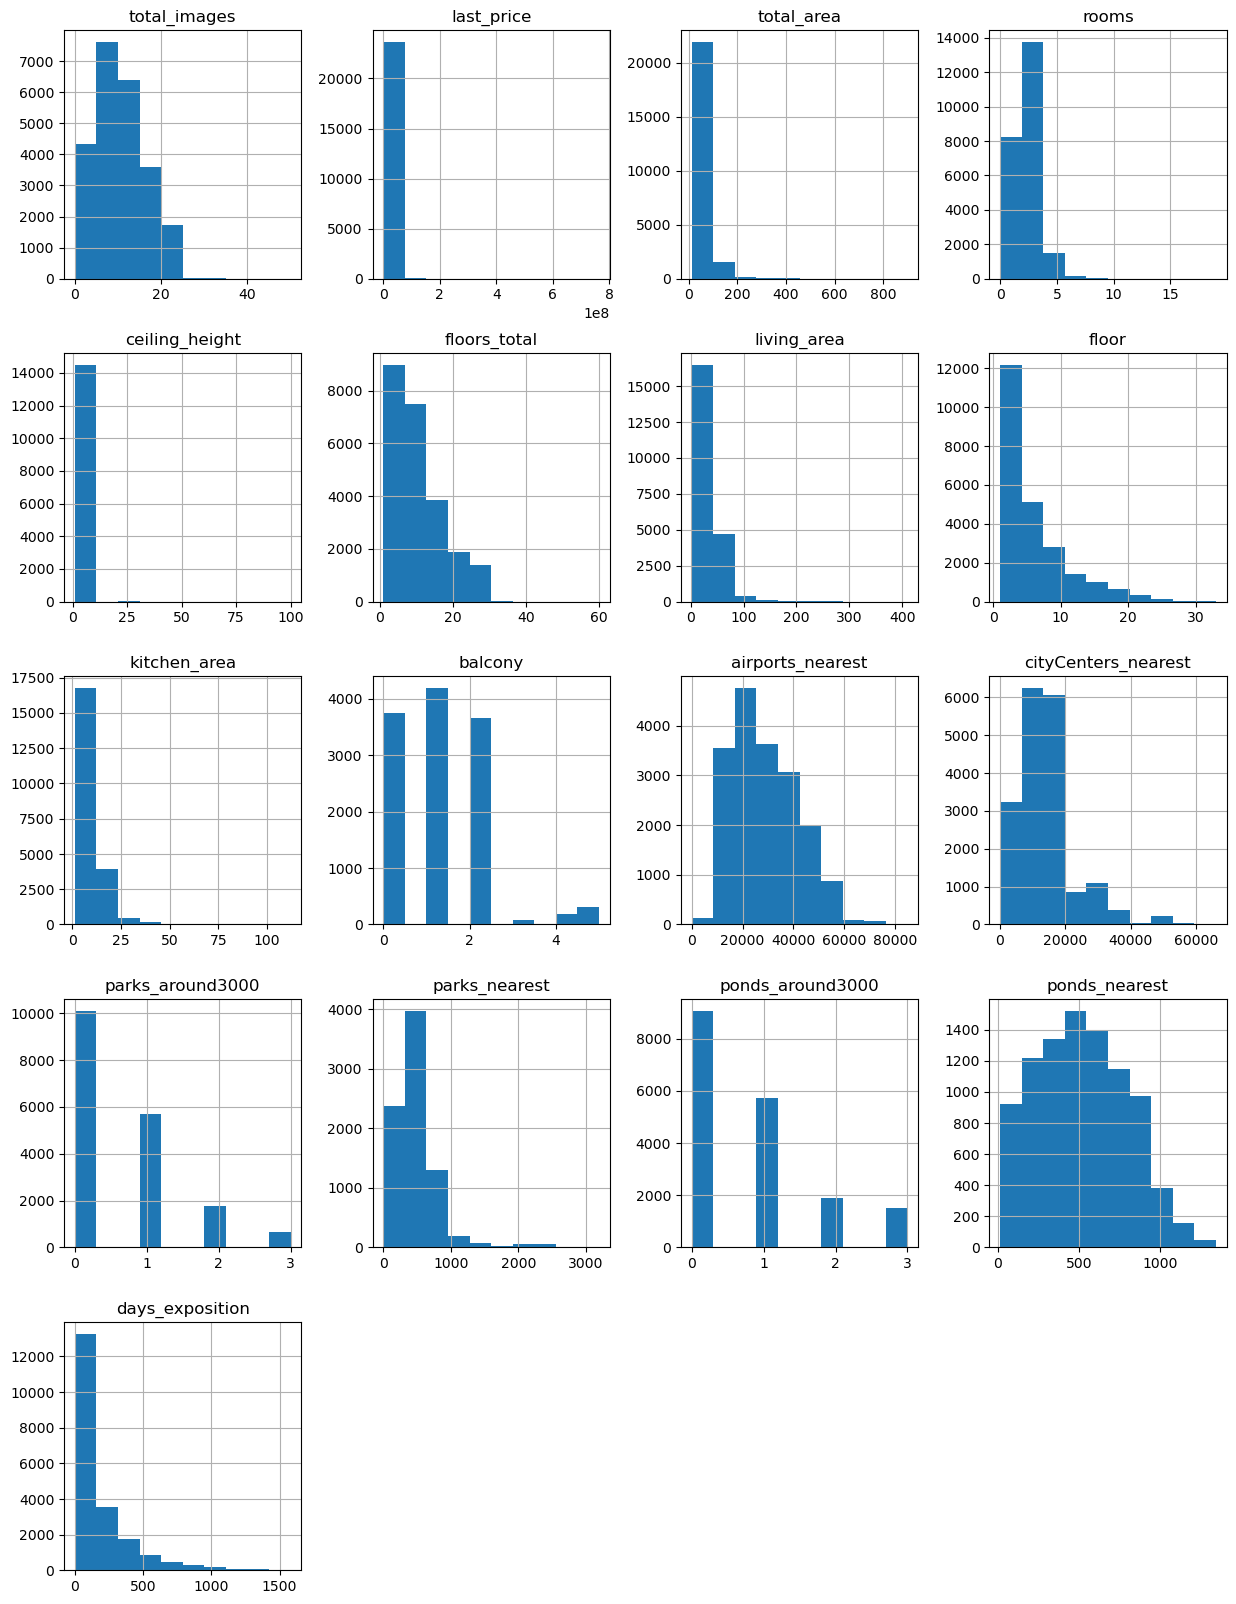

In [5]:
data.hist(figsize=(15, 20));

**Вывод** Данные успешно загружены. Судя по тому, насколько гистограммы  last_price, total_area, living_area, kitchen_area, rooms, celling_height распологаются в левой части графика, то там ожидаются выбросы на больших значениях

### Выполним предобработку данных

Выведем количество пропущенных значений для каждого столбца.

In [6]:
data.isna().mean() * 100

total_images            0.00
last_price              0.00
total_area              0.00
first_day_exposition    0.00
rooms                   0.00
ceiling_height         38.80
floors_total            0.36
living_area             8.03
floor                   0.00
is_apartment           88.29
studio                  0.00
open_plan               0.00
kitchen_area            9.61
balcony                48.61
locality_name           0.21
airports_nearest       23.38
cityCenters_nearest    23.29
parks_around3000       23.28
parks_nearest          65.91
ponds_around3000       23.28
ponds_nearest          61.56
days_exposition        13.42
dtype: float64

Попробуем заполнить пропуски, где это возможно

Можем предположить, что если продавец не указал число балконов, то их нет

In [7]:
data['balcony'] = data['balcony'].fillna(0)

Можем предположить, что если продавец не указал, является ли жильё аппартаментами, то это значит, что не является

In [8]:
data['is_apartment'] = data['is_apartment'].fillna(False)

Пропуски в названии населённого пункта (столбец *locality_name*) заполним пустой строкой

In [9]:
data['locality_name'] = data['locality_name'].fillna('')

Посмотрим в каких случаях не указано общее количество этажей в доме

In [10]:
data[data['floors_total'].isna()]

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
186,12,"11,640,000.00",65.20,2018-10-02T00:00:00,2,NaN,NaN,30.80,4,False,...,12.00,0.00,Санкт-Петербург,"39,197.00","12,373.00",1.00,123.00,0.00,NaN,49.00
237,4,"2,438,033.00",28.10,2016-11-23T00:00:00,1,NaN,NaN,20.75,1,False,...,NaN,0.00,Санкт-Петербург,"22,041.00","17,369.00",0.00,NaN,1.00,374.00,251.00
457,4,"9,788,348.00",70.80,2015-08-01T00:00:00,2,NaN,NaN,38.40,12,False,...,10.63,0.00,Санкт-Петербург,"37,364.00","8,322.00",2.00,309.00,2.00,706.00,727.00
671,4,"6,051,191.00",93.60,2017-04-06T00:00:00,3,NaN,NaN,47.10,8,False,...,16.80,0.00,Санкт-Петербург,"22,041.00","17,369.00",0.00,NaN,1.00,374.00,123.00
1757,5,"3,600,000.00",39.00,2017-04-22T00:00:00,1,NaN,NaN,NaN,9,False,...,NaN,0.00,Санкт-Петербург,"22,735.00","11,618.00",1.00,835.00,1.00,652.00,77.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22542,5,"8,500,000.00",63.50,2017-05-24T00:00:00,2,2.80,NaN,NaN,3,False,...,NaN,0.00,Санкт-Петербург,"51,340.00","15,363.00",0.00,NaN,1.00,853.00,512.00
22656,4,"4,574,160.00",64.50,2017-04-02T00:00:00,2,NaN,NaN,31.70,20,False,...,14.40,0.00,Санкт-Петербург,"22,041.00","17,369.00",0.00,NaN,1.00,374.00,127.00
22808,0,"14,569,263.00",110.40,2016-11-20T00:00:00,3,NaN,NaN,45.38,6,False,...,23.42,0.00,Санкт-Петербург,"19,095.00","4,529.00",0.00,NaN,0.00,NaN,260.00
23590,0,"21,187,872.00",123.30,2017-04-25T00:00:00,3,NaN,NaN,50.40,18,False,...,23.60,0.00,Санкт-Петербург,"19,095.00","4,529.00",0.00,NaN,0.00,NaN,104.00


Каких-то взаимосвязей не видно, но таких записей всего 86. Их удаление не повлият существенно на данные, но не будет мешать в будущем

In [11]:
data.dropna(subset=['floors_total'])
data = data.reset_index(drop=True)

In [12]:
round(data.isna().mean() * 100, 2)

total_images            0.00
last_price              0.00
total_area              0.00
first_day_exposition    0.00
rooms                   0.00
ceiling_height         38.80
floors_total            0.36
living_area             8.03
floor                   0.00
is_apartment            0.00
studio                  0.00
open_plan               0.00
kitchen_area            9.61
balcony                 0.00
locality_name           0.00
airports_nearest       23.38
cityCenters_nearest    23.29
parks_around3000       23.28
parks_nearest          65.91
ponds_around3000       23.28
ponds_nearest          61.56
days_exposition        13.42
dtype: float64

In [13]:
avg_living_area_ratio = data['living_area']. mean() / data['total_area']. mean()
avg_kitchen_ratio = data['kitchen_area']. mean() / data['total_area']. mean()
med_ceiling_height = data['ceiling_height'].median()

In [14]:
for i in data.loc[data['living_area'].isna()].index:
    data.loc[i, 'living_area'] = data.loc[i, 'total_area'] * avg_living_area_ratio 

In [15]:
for i in data.loc[data['kitchen_area'].isna()].index:
    data.loc[i, 'kitchen_area'] = data.loc[i, 'total_area'] * avg_kitchen_ratio

In [16]:
data.loc[data['ceiling_height'].isna(), 'ceiling_height'] = med_ceiling_height

In [17]:
round(data.isna().sum() / len(data) * 100, 2)

total_images            0.00
last_price              0.00
total_area              0.00
first_day_exposition    0.00
rooms                   0.00
ceiling_height          0.00
floors_total            0.36
living_area             0.00
floor                   0.00
is_apartment            0.00
studio                  0.00
open_plan               0.00
kitchen_area            0.00
balcony                 0.00
locality_name           0.00
airports_nearest       23.38
cityCenters_nearest    23.29
parks_around3000       23.28
parks_nearest          65.91
ponds_around3000       23.28
ponds_nearest          61.56
days_exposition        13.42
dtype: float64

**Приведение типов данных**

Переведем столбец *first_day_exposition* в тип *datetime*

In [18]:
# 2019-03-07T00:00:00
data['first_day_exposition'] = pd.to_datetime(data['first_day_exposition'], format='%Y-%m-%dT%H:%M:%S')

Переведём столбцы *floors_total* и *balcony* к типу *int*, т.к. эти показатели описывают целочисленные значения количества этажей и балконов

In [19]:
data['floors_total'] = data['floors_total'].astype('int', errors='ignore')

In [20]:
data['balcony'] = data['balcony'].astype('int', errors='ignore')

Переведём столбцы *parks_around3000* и *ponds_around3000* к типу int, т.к. эти показатели округлены до целого значения

In [21]:
data['parks_around3000'] = data['parks_around3000'].astype('int', errors='ignore')
data['ponds_around3000'] = data['ponds_around3000'].astype('int', errors='ignore')

Столбцы *airports_nearest, cityCenters_nearest, parks_nearest, ponds_around3000, days_exposition* к типу int не имеет смысла из-за отсутствующих данных

In [22]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          23699 non-null  int64         
 1   last_price            23699 non-null  float64       
 2   total_area            23699 non-null  float64       
 3   first_day_exposition  23699 non-null  datetime64[ns]
 4   rooms                 23699 non-null  int64         
 5   ceiling_height        23699 non-null  float64       
 6   floors_total          23613 non-null  float64       
 7   living_area           23699 non-null  float64       
 8   floor                 23699 non-null  int64         
 9   is_apartment          23699 non-null  bool          
 10  studio                23699 non-null  bool          
 11  open_plan             23699 non-null  bool          
 12  kitchen_area          23699 non-null  float64       
 13  balcony         

**Устраним дупликаты в названии населённых пунктов**

In [23]:
un_loc = data['locality_name'].unique()
un_loc

array(['Санкт-Петербург', 'посёлок Шушары', 'городской посёлок Янино-1',
       'посёлок Парголово', 'посёлок Мурино', 'Ломоносов', 'Сертолово',
       'Петергоф', 'Пушкин', 'деревня Кудрово', 'Коммунар', 'Колпино',
       'поселок городского типа Красный Бор', 'Гатчина', 'поселок Мурино',
       'деревня Фёдоровское', 'Выборг', 'Кронштадт', 'Кировск',
       'деревня Новое Девяткино', 'посёлок Металлострой',
       'посёлок городского типа Лебяжье',
       'посёлок городского типа Сиверский', 'поселок Молодцово',
       'поселок городского типа Кузьмоловский',
       'садовое товарищество Новая Ропша', 'Павловск',
       'деревня Пикколово', 'Всеволожск', 'Волхов', 'Кингисепп',
       'Приозерск', 'Сестрорецк', 'деревня Куттузи', 'посёлок Аннино',
       'поселок городского типа Ефимовский', 'посёлок Плодовое',
       'деревня Заклинье', 'поселок Торковичи', 'поселок Первомайское',
       'Красное Село', 'посёлок Понтонный', 'Сясьстрой', 'деревня Старая',
       'деревня Лесколово', '

In [24]:
len(un_loc)

365

In [25]:
loces =[]
word_array = ['посёлок ', 'поселок ', 'городской ', 'деревня ', 'городского типа ', 'садовое ', 'некоммерчесское ', 
              'товарищество ', 'село ', 'станции ', 'при железнодорожной ', 'коттеджный ']
for loc_name in un_loc:
    new_loc = loc_name
    for word in word_array:
        new_loc  = new_loc.replace(word, '')    
    loces.append(new_loc)

In [26]:
for name in loces:
    temp = data[data['locality_name'].str.contains(name)]
    print(name, ' - ', temp['locality_name'].unique())

Санкт-Петербург  -  ['Санкт-Петербург']
Шушары  -  ['посёлок Шушары']
Янино-1  -  ['городской посёлок Янино-1' 'городской поселок Янино-1']
Парголово  -  ['посёлок Парголово']
Мурино  -  ['посёлок Мурино' 'поселок Мурино' 'Мурино']
Ломоносов  -  ['Ломоносов']
Сертолово  -  ['Сертолово']
Петергоф  -  ['Петергоф']
Пушкин  -  ['Пушкин']
Кудрово  -  ['деревня Кудрово' 'Кудрово']
Коммунар  -  ['Коммунар' 'поселок Коммунары']
Колпино  -  ['Колпино']
Красный Бор  -  ['поселок городского типа Красный Бор'
 'посёлок городского типа Красный Бор']
Гатчина  -  ['Гатчина']
Мурино  -  ['посёлок Мурино' 'поселок Мурино' 'Мурино']
Фёдоровское  -  ['деревня Фёдоровское' 'городской посёлок Фёдоровское']
Выборг  -  ['Выборг']
Кронштадт  -  ['Кронштадт']
Кировск  -  ['Кировск']
Новое Девяткино  -  ['деревня Новое Девяткино']
Металлострой  -  ['посёлок Металлострой']
Лебяжье  -  ['посёлок городского типа Лебяжье' 'поселок городского типа Лебяжье']
Сиверский  -  ['посёлок городского типа Сиверский']
Молодцо

Павлово  -  ['село Павлово' 'городской посёлок Павлово'
 'посёлок городского типа Павлово']
Агалатово  -  ['деревня Агалатово']
Новогорелово  -  ['посёлок Новогорелово']
Лесогорский  -  ['городской посёлок Лесогорский' 'поселок городского типа Лесогорский']
Лаголово  -  ['деревня Лаголово']
Цвелодубово  -  ['поселок Цвелодубово']
Рахья  -  ['поселок городского типа Рахья' 'садовое товарищество Рахья']
Вырица  -  ['посёлок городского типа Вырица' 'поселок городского типа Вырица']
Белогорка  -  ['деревня Белогорка']
Заводской  -  ['поселок Заводской']
Новоселье  -  ['городской посёлок Новоселье']
Большие Колпаны  -  ['деревня Большие Колпаны']
Горбунки  -  ['деревня Горбунки']
Батово  -  ['деревня Батово']
Заневка  -  ['деревня Заневка']
Иссад  -  ['деревня Иссад']
Приморск  -  ['Приморск']
Фёдоровское  -  ['деревня Фёдоровское' 'городской посёлок Фёдоровское']
Мистолово  -  ['деревня Мистолово']
Новая Ладога  -  ['Новая Ладога']
Зимитицы  -  ['поселок Зимитицы' 'деревня Зимитицы']
Барыш

Мельниково  -  ['поселок Мельниково' 'посёлок Мельниково']
Назия  -  ['городской посёлок Назия' 'поселок городского типа Назия']
Старая Пустошь  -  ['деревня Старая Пустошь']
Коммунары  -  ['поселок Коммунары']
Починок  -  ['поселок Починок']
Вознесенье  -  ['посёлок городского типа Вознесенье']
Разбегаево  -  ['деревня Разбегаево']
Рябово  -  ['поселок Рябово' 'поселок городского типа Рябово'
 'посёлок городского типа Рябово']
Гладкое  -  ['поселок Гладкое']
Приветнинское  -  ['поселок станции Приветнинское'
 'посёлок при железнодорожной станции Приветнинское']
Тёсово-4  -  ['поселок Тёсово-4']
Жилгородок  -  ['поселок Жилгородок' 'посёлок Жилгородок']
Бор  -  ['поселок городского типа Красный Бор' 'Сосновый Бор'
 'посёлок городского типа Красный Бор' 'деревня Чудской Бор' 'деревня Бор'
 'деревня Трубников Бор' 'посёлок Пансионат Зелёный Бор'
 'поселок Пансионат Зелёный Бор' 'деревня Борисова Грива']
Коробицыно  -  ['посёлок Коробицыно' 'поселок Коробицыно']
Большая Вруда  -  ['деревн

Самый простой способ вижу удалить все наименования муниципальных образований и оставить только название населённого пункта.
    
Но меня смущают 'село Павлово' 'посёлок городского типа Павлово - это совершенно разные места, находящиеся в разных районах Ленинградской области. То же самое с 'посёлок городского типа Рахья' 'садовое товарищество Рахья' - это несколько разные места. Поэтому обрабатываю более тонко

'Никольское' 'село Никольское' - разные места

In [27]:
data['locality_name'] = data['locality_name'].str.replace('поселок', 'посёлок')

In [28]:
proc_loces = ['Мурино', 'Кудрово', 'Никольское', 'Кудрово', 'Рощино', 'Павлово', 'Советский', 'Большая Ижора', 'Лесогорский',
             'Фёдоровское', 'Зимитицы', 'Рябово', 'Мга', 'Вещево', 'Калитино', 'Щеглово', 'Рабитицы', 'Назия', 'Гарболово',
             'Приветнинское', 'Любань', 'Громово', 'Советский']
for name in proc_loces:
    data.loc[data['locality_name'].str.contains(name), 'locality_name'] = name

In [29]:
data['locality_name'].unique()

array(['Санкт-Петербург', 'посёлок Шушары', 'городской посёлок Янино-1',
       'посёлок Парголово', 'Мурино', 'Ломоносов', 'Сертолово',
       'Петергоф', 'Пушкин', 'Кудрово', 'Коммунар', 'Колпино',
       'посёлок городского типа Красный Бор', 'Гатчина', 'Фёдоровское',
       'Выборг', 'Кронштадт', 'Кировск', 'деревня Новое Девяткино',
       'посёлок Металлострой', 'посёлок городского типа Лебяжье',
       'посёлок городского типа Сиверский', 'посёлок Молодцово',
       'посёлок городского типа Кузьмоловский',
       'садовое товарищество Новая Ропша', 'Павловск',
       'деревня Пикколово', 'Всеволожск', 'Волхов', 'Кингисепп',
       'Приозерск', 'Сестрорецк', 'деревня Куттузи', 'посёлок Аннино',
       'посёлок городского типа Ефимовский', 'посёлок Плодовое',
       'деревня Заклинье', 'посёлок Торковичи', 'посёлок Первомайское',
       'Красное Село', 'посёлок Понтонный', 'Сясьстрой', 'деревня Старая',
       'деревня Лесколово', 'посёлок Новый Свет', 'Сланцы',
       'село Путил

In [30]:
len(data['locality_name'].unique())

309

In [31]:
data.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,"13,000,000.00",108.00,2019-03-07,3,2.70,16.00,51.00,8,False,...,25.00,0,Санкт-Петербург,"18,863.00","16,028.00",1.00,482.00,2.00,755.00,NaN
1,7,"3,350,000.00",40.40,2018-12-04,1,2.65,11.00,18.60,1,False,...,11.00,2,посёлок Шушары,"12,817.00","18,603.00",0.00,NaN,0.00,NaN,81.00
2,10,"5,196,000.00",56.00,2015-08-20,2,2.65,5.00,34.30,4,False,...,8.30,0,Санкт-Петербург,"21,741.00","13,933.00",1.00,90.00,2.00,574.00,558.00
3,0,"64,900,000.00",159.00,2015-07-24,3,2.65,14.00,90.79,9,False,...,27.85,0,Санкт-Петербург,"28,098.00","6,800.00",2.00,84.00,3.00,234.00,424.00
4,2,"10,000,000.00",100.00,2018-06-19,2,3.03,14.00,32.00,13,False,...,41.00,0,Санкт-Петербург,"31,856.00","8,098.00",2.00,112.00,1.00,48.00,121.00


In [32]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          23699 non-null  int64         
 1   last_price            23699 non-null  float64       
 2   total_area            23699 non-null  float64       
 3   first_day_exposition  23699 non-null  datetime64[ns]
 4   rooms                 23699 non-null  int64         
 5   ceiling_height        23699 non-null  float64       
 6   floors_total          23613 non-null  float64       
 7   living_area           23699 non-null  float64       
 8   floor                 23699 non-null  int64         
 9   is_apartment          23699 non-null  bool          
 10  studio                23699 non-null  bool          
 11  open_plan             23699 non-null  bool          
 12  kitchen_area          23699 non-null  float64       
 13  balcony         

**Выводы**
* Обработаны отсутствующие значения в столбцах: 'balcony', 'is_apartment', 'locality_name'. Отсутствующие значения в столбцах 'living_area', 'kitchen_area' и 'ceiling_height' заполнены с учётом средних и медианных значений
* Значения в столбцах 'first_day_exposition', 'floors_total', 'balcony' приведены к нужным типам данных
* Обработаны неявные дупликаты в названиях населённых пунктов

### Добавим в таблицу новые столбцы

Добавим столбец с ценой за квадратный метр

In [33]:
data['metr_price'] = data['last_price'] / data['total_area']

Добавим столбцы с днём недели, месяца и года публикации объявления

In [34]:
data['dw_exposition'] = data['first_day_exposition'].dt.weekday
data['month_exposition'] = data['first_day_exposition'].dt.month
data['year_exposition'] = data['first_day_exposition'].dt.year

Добавим столбец с типом этажа ("первый", "последний", "другой"). Для этого сначала напишем функцию

In [35]:
def floor_type(row):
    if row['floor'] == 1: 
        return "первый"
    elif row['floor'] == row['floors_total']:
        return 'последний'
    else:
        return 'другой'

In [36]:
data['floor_category'] = data.apply(floor_type, axis=1)

Добавим столбец с расстоянием до центра в километрах. Для этого сначала определим функцию

In [37]:
def m_to_km(meters):    
    if (math.isnan(meters)):
        return float('nan')
    else:
        return round(meters  / 1000)

In [38]:
data['center_km'] = data['cityCenters_nearest'].apply(m_to_km)

In [39]:
data.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,metr_price,dw_exposition,month_exposition,year_exposition,floor_category,center_km
0,20,"13,000,000.00",108.00,2019-03-07,3,2.70,16.00,51.00,8,False,...,482.00,2.00,755.00,NaN,"120,370.37",3,3,2019,другой,16.00
1,7,"3,350,000.00",40.40,2018-12-04,1,2.65,11.00,18.60,1,False,...,NaN,0.00,NaN,81.00,"82,920.79",1,12,2018,первый,19.00
2,10,"5,196,000.00",56.00,2015-08-20,2,2.65,5.00,34.30,4,False,...,90.00,2.00,574.00,558.00,"92,785.71",3,8,2015,другой,14.00
3,0,"64,900,000.00",159.00,2015-07-24,3,2.65,14.00,90.79,9,False,...,84.00,3.00,234.00,424.00,"408,176.10",4,7,2015,другой,7.00
4,2,"10,000,000.00",100.00,2018-06-19,2,3.03,14.00,32.00,13,False,...,112.00,1.00,48.00,121.00,"100,000.00",1,6,2018,другой,8.00


**Выводы** На этом этапе в датафрейм добавлены  дополнительные столбцы ('metr_price', 'dw_exposition', 'month_exposition', 'year_exposition', 'floor_category', 'center_km') полезные для будущего  анализа

### Исследовательский анализ данных

**Проведём анализ общей площади объектов**

In [40]:
data['total_area'].describe()

count   23,699.00
mean        60.35
std         35.65
min         12.00
25%         40.00
50%         52.00
75%         69.90
max        900.00
Name: total_area, dtype: float64

Отобразим диаграмму размаха от общей площади

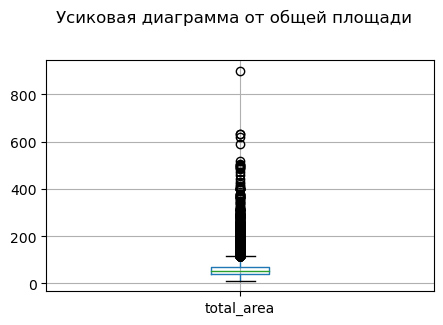

In [41]:
data.boxplot(column='total_area', figsize=(5, 3));
plt.suptitle('Усиковая диаграмма от общей площади', x=0.5, y=1.05, ha='center', fontsize='large');

Отобразим гистограмму от общей площади на всём диапазоне значений и в диапазоне до 400м2

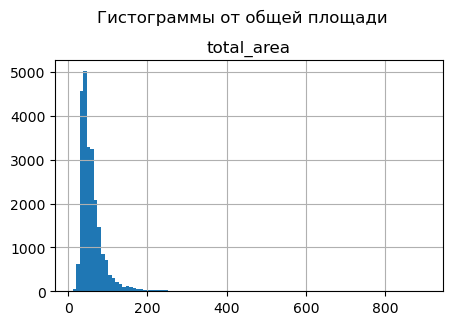

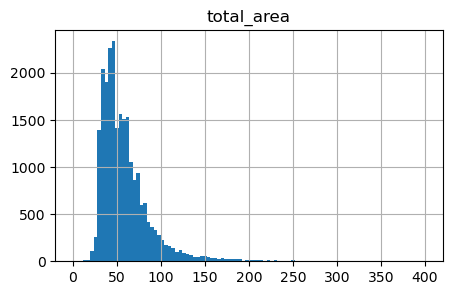

In [42]:
data.hist('total_area', bins=100, figsize=(5,3));
plt.suptitle('Гистограммы от общей площади', x=0.5, y=1.05, ha='center', fontsize='large')
data.hist('total_area', bins=100, range=(0, 400), figsize=(5,3));
plt.show()

Большинство квартир площадью до 250м2. Квартир площадью более 400 м2 явно выбиваются из статистики. Удалим их

In [43]:
data[data['total_area'] >= 400]

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,metr_price,dw_exposition,month_exposition,year_exposition,floor_category,center_km
660,3,"49,950,000.00",483.90,2017-10-04,7,3.20,6.00,312.50,4,False,...,461.00,3.00,22.00,391.00,"103,223.81",2,10,2017,другой,1.00
3117,19,"140,000,000.00",631.00,2019-03-30,7,2.65,5.00,360.29,5,False,...,NaN,2.00,210.00,NaN,"221,870.05",5,3,2019,последний,5.00
3676,12,"28,789,000.00",441.98,2019-01-23,4,2.65,6.00,252.36,6,False,...,NaN,0.00,NaN,NaN,"65,136.43",2,1,2019,последний,5.00
4237,1,"50,000,000.00",517.00,2017-10-14,7,2.65,4.00,332.00,3,False,...,477.00,2.00,540.00,NaN,"96,711.80",5,10,2017,другой,2.00
5358,20,"65,000,000.00",590.00,2019-02-14,15,3.50,6.00,409.00,3,False,...,767.00,0.00,NaN,14.00,"110,169.49",3,2,2019,другой,5.00
5873,0,"38,000,000.00",400.00,2019-03-15,7,3.60,3.00,228.39,1,False,...,271.00,0.00,NaN,NaN,"95,000.00",4,3,2019,первый,5.00
5893,3,"230,000,000.00",500.00,2017-05-31,6,2.65,7.00,285.49,7,False,...,NaN,2.00,198.00,50.00,"460,000.00",2,5,2017,последний,5.00
6221,8,"34,000,000.00",470.30,2018-01-14,4,2.65,3.00,248.70,3,False,...,852.00,3.00,122.00,179.00,"72,294.28",6,1,2018,последний,15.00
6621,20,"99,000,000.00",488.00,2017-04-09,5,2.95,20.00,216.00,17,False,...,646.00,1.00,368.00,351.00,"202,868.85",6,4,2017,другой,5.00
8018,20,"84,000,000.00",507.00,2015-12-17,5,4.45,7.00,301.50,7,True,...,110.00,0.00,NaN,"1,078.00","165,680.47",3,12,2015,последний,6.00


In [44]:
data = data[data['total_area'] < 400]

Посмотрим объявления с недвжимостью малой метражности

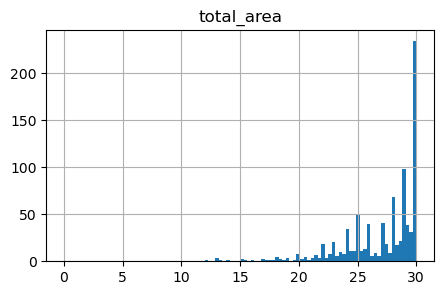

In [45]:
data.hist('total_area', bins=100, range=(0, 30), figsize=(5,3));

In [46]:
data[data['total_area'] < 15]

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,metr_price,dw_exposition,month_exposition,year_exposition,floor_category,center_km
17961,3,"1,400,000.00",13.00,2017-12-03,1,2.60,9.00,7.42,1,False,...,NaN,1.00,185.00,410.00,"107,692.31",6,12,2017,первый,16.00
19546,3,"1,850,000.00",13.00,2019-03-11,1,3.40,5.00,7.42,2,False,...,644.00,0.00,NaN,24.00,"142,307.69",0,3,2019,другой,5.00
19558,2,"1,686,000.00",13.20,2018-12-17,1,2.65,5.00,7.54,1,False,...,361.00,1.00,155.00,19.00,"127,727.27",0,12,2018,первый,4.00
19642,5,"1,190,000.00",14.00,2018-07-29,1,2.65,5.00,11.00,1,False,...,NaN,0.00,NaN,4.00,"85,000.00",6,7,2018,первый,11.00
19807,0,"3,800,000.00",13.00,2018-07-04,1,2.65,5.00,10.00,3,False,...,592.00,3.00,27.00,9.00,"292,307.69",2,7,2018,другой,1.00
19904,4,"2,400,000.00",12.00,2017-07-19,1,2.55,5.00,10.00,2,False,...,886.00,2.00,45.00,200.00,"200,000.00",2,7,2017,другой,1.00


Объявлений с недвижимостью площадью менее 15м2 мало, но они появляются в соответствии с распределением и удалять их не будем

In [47]:
data['total_area'].describe()

count   23,673.00
mean        59.87
std         32.42
min         12.00
25%         40.00
50%         52.00
75%         69.70
max        399.00
Name: total_area, dtype: float64

**Вывод** После удаления объявлений с необычно большой общей площадью получили средняя площадь квартиры - 60м2, медианное значение отличается не сильно и стоставляет 52м2.

**Проведём анализ жилой площади объектов**

In [48]:
data['living_area'].describe()

count   23,673.00
mean        34.33
std         20.77
min          2.00
25%         19.00
50%         30.00
75%         42.10
max        264.50
Name: living_area, dtype: float64

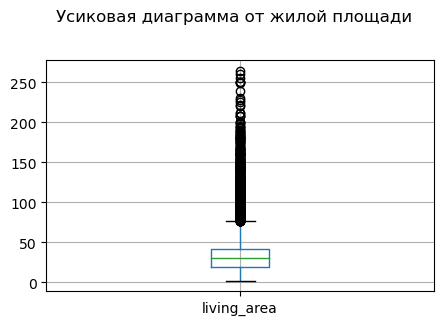

In [49]:
data.boxplot(column='living_area', figsize=(5, 3));
plt.suptitle('Усиковая диаграмма от жилой площади', x=0.5, y=1.05, ha='center', fontsize='large');

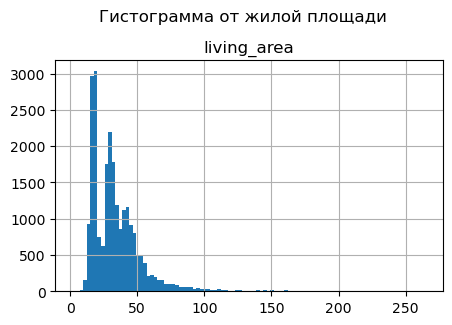

In [50]:
data.hist('living_area', bins=100, figsize=(5,3));
plt.suptitle('Гистограмма от жилой площади', x=0.5, y=1.05, ha='center', fontsize='large');

Видим значения жилой площади в 2м2. Посмотрим объявления с самыми низкими значения столбца *living_area*

In [51]:
data.sort_values(by='living_area').head(15)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,metr_price,dw_exposition,month_exposition,year_exposition,floor_category,center_km
13915,20,"6,350,000.00",52.00,2018-02-06,2,3.00,6.00,2.00,2,False,...,NaN,1.00,"1,012.00",91.00,"122,115.38",1,2,2018,другой,7.00
21758,0,"2,330,000.00",23.00,2018-01-01,0,2.65,24.00,2.00,22,False,...,NaN,NaN,NaN,66.00,"101,304.35",0,1,2018,другой,NaN
3242,7,"4,440,000.00",41.00,2017-07-02,1,2.65,17.00,3.00,17,False,...,NaN,0.00,NaN,216.00,"108,292.68",6,7,2017,последний,13.00
23574,14,"64,990,000.00",139.00,2015-11-24,3,3.00,8.00,3.00,8,False,...,630.00,3.00,100.00,280.00,"467,553.96",1,11,2015,последний,6.00
17582,11,"2,680,000.00",22.00,2018-08-11,0,2.65,25.00,5.00,8,False,...,835.00,1.00,652.00,70.00,"121,818.18",5,8,2018,другой,12.00
21943,15,"6,100,000.00",77.60,2019-02-28,4,2.50,9.00,5.40,1,False,...,584.00,0.00,NaN,33.00,"78,608.25",3,2,2019,первый,11.00
16431,13,"3,799,000.00",31.00,2018-04-12,1,2.60,5.00,6.00,1,False,...,430.00,0.00,NaN,168.00,"122,548.39",3,4,2018,первый,5.00
19251,19,"4,050,000.00",33.00,2018-10-15,1,2.50,22.00,6.50,21,False,...,458.00,0.00,NaN,44.00,"122,727.27",0,10,2018,другой,11.00
17961,3,"1,400,000.00",13.00,2017-12-03,1,2.60,9.00,7.42,1,False,...,NaN,1.00,185.00,410.00,"107,692.31",6,12,2017,первый,16.00
19546,3,"1,850,000.00",13.00,2019-03-11,1,3.40,5.00,7.42,2,False,...,644.00,0.00,NaN,24.00,"142,307.69",0,3,2019,другой,5.00


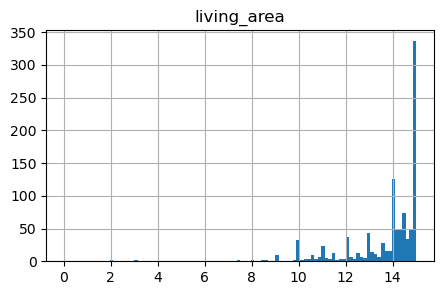

In [52]:
data.hist('living_area', bins=100, range=(0, 15), figsize=(5,3));

In [53]:
len(data[data['living_area'] < 8])

11

**Квартира с жилой площадью 2м2 - это явная аномалия. Так же можно назвать сомнительными объявления с жилой площадью менее 8м2. Таких записей всего 8.Удалим их**

In [54]:
data = data.loc[data['living_area'] >= 8]

In [55]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 23662 entries, 0 to 23698
Data columns (total 28 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          23662 non-null  int64         
 1   last_price            23662 non-null  float64       
 2   total_area            23662 non-null  float64       
 3   first_day_exposition  23662 non-null  datetime64[ns]
 4   rooms                 23662 non-null  int64         
 5   ceiling_height        23662 non-null  float64       
 6   floors_total          23576 non-null  float64       
 7   living_area           23662 non-null  float64       
 8   floor                 23662 non-null  int64         
 9   is_apartment          23662 non-null  bool          
 10  studio                23662 non-null  bool          
 11  open_plan             23662 non-null  bool          
 12  kitchen_area          23662 non-null  float64       
 13  balcony              

Так же удалим выбросы значений выше 200м2

In [56]:
data[data['living_area'] >= 200]

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,metr_price,dw_exposition,month_exposition,year_exposition,floor_category,center_km
581,20,"65,000,000.00",365.00,2019-03-18,7,2.90,7.00,208.41,7,False,...,378.00,3.00,58.00,NaN,"178,082.19",0,3,2019,последний,2.00
793,20,"135,000,000.00",310.00,2018-05-22,4,3.30,5.00,250.00,2,False,...,295.00,3.00,190.00,342.00,"435,483.87",1,5,2018,другой,7.00
866,5,"25,000,000.00",363.00,2017-12-23,14,3.16,5.00,222.00,4,False,...,NaN,2.00,435.00,418.00,"68,870.52",5,12,2017,другой,8.00
1085,16,"75,000,000.00",323.00,2017-07-10,5,4.00,5.00,255.70,4,False,...,398.00,2.00,515.00,259.00,"232,198.14",0,7,2017,другой,1.00
1388,20,"59,800,000.00",399.00,2015-01-21,5,5.60,6.00,227.82,6,False,...,149.00,2.00,577.00,719.00,"149,874.69",2,1,2015,последний,7.00
1494,10,"65,000,000.00",364.00,2018-11-27,7,3.90,6.00,250.00,3,False,...,NaN,1.00,689.00,46.00,"178,571.43",1,11,2018,другой,3.00
2580,6,"30,900,000.00",338.60,2017-10-16,7,3.86,6.00,230.00,4,False,...,NaN,0.00,NaN,406.00,"91,258.12",0,10,2017,другой,6.00
6183,10,"84,382,000.00",363.10,2018-10-07,3,2.65,16.00,207.32,12,False,...,NaN,2.00,182.00,NaN,"232,393.28",6,10,2018,другой,5.00
7857,11,"150,000,000.00",230.00,2017-10-25,8,2.65,8.00,220.00,8,False,...,116.00,0.00,NaN,135.00,"652,173.91",2,10,2017,последний,6.00
10246,10,"25,023,000.00",253.70,2017-11-10,6,2.65,4.00,200.00,2,False,...,103.00,3.00,155.00,90.00,"98,632.24",4,11,2017,другой,1.00


In [57]:
data = data[data['living_area'] < 200]

In [58]:
data['living_area'].describe()

count   23,642.00
mean        34.18
std         19.98
min          8.00
25%         19.00
50%         30.00
75%         42.00
max        199.00
Name: living_area, dtype: float64

**Вывод** Среднее значение жилой площади в объявлении - 34,1 м2, медианное значение отличается не сильно и стоставляет 30м2. В  ходе анализа были выявлены объявления с аномально низкими значениями жилой площади помещений, такие записи были удалены

**Проведём анализ площади кухни**

In [59]:
data['kitchen_area'].describe()

count   23,642.00
mean        10.44
std          5.74
min          1.30
25%          7.00
50%          9.00
75%         12.00
max        107.00
Name: kitchen_area, dtype: float64

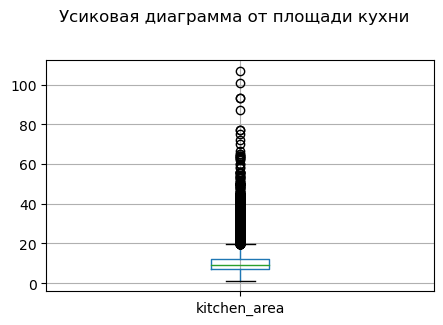

In [60]:
data.boxplot(column='kitchen_area', figsize=(5, 3));
plt.suptitle('Усиковая диаграмма от площади кухни', x=0.5, y=1.05, ha='center', fontsize='large');

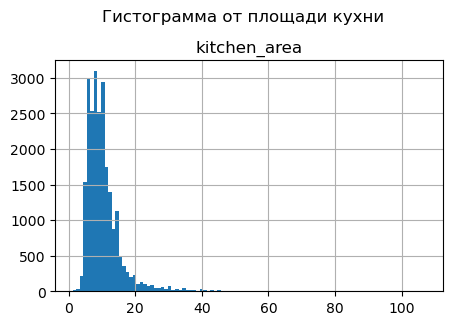

In [61]:
data.hist('kitchen_area', bins=100, figsize=(5,3));
plt.suptitle('Гистограмма от площади кухни', x=0.5, y=1.05, ha='center', fontsize='large');

Удалим объявления с площадью кухни больше 60м2

In [62]:
data[data['kitchen_area'] >= 60]

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,metr_price,dw_exposition,month_exposition,year_exposition,floor_category,center_km
492,18,"95,000,000.00",216.00,2017-12-05,4,3.00,5.00,86.00,4,False,...,138.00,3.00,620.00,14.00,"439,814.81",1,12,2017,другой,0.00
1026,20,"155,000,000.00",310.00,2018-10-12,5,5.30,3.00,190.00,3,False,...,NaN,1.00,603.00,NaN,"500,000.00",4,10,2018,последний,5.00
2489,9,"12,500,000.00",255.00,2017-04-21,3,2.65,2.00,153.90,2,False,...,NaN,3.00,198.00,102.00,"49,019.61",4,4,2017,последний,7.00
3561,5,"12,300,000.00",115.00,2017-08-09,3,2.70,20.00,45.00,16,False,...,NaN,0.00,NaN,63.00,"106,956.52",2,8,2017,другой,14.00
4394,20,"57,000,000.00",174.00,2015-11-09,3,3.20,10.00,95.00,6,False,...,193.00,3.00,199.00,"1,039.00","327,586.21",0,11,2015,другой,4.00
6193,19,"24,300,000.00",230.00,2016-06-03,4,2.65,3.00,90.00,2,False,...,NaN,1.00,345.00,397.00,"105,652.17",4,6,2016,другой,15.00
7543,20,"130,000,000.00",307.80,2016-04-24,5,2.65,4.00,187.90,3,False,...,NaN,1.00,603.00,"1,094.00","422,352.18",6,4,2016,другой,5.00
7674,20,"131,000,000.00",380.00,2016-09-23,5,3.90,6.00,150.00,4,False,...,161.00,1.00,635.00,901.00,"344,736.84",4,9,2016,другой,5.00
10867,1,"56,844,500.00",177.90,2015-01-15,3,2.65,6.00,87.20,5,True,...,160.00,3.00,569.00,NaN,"319,530.64",3,1,2015,другой,0.00
13139,20,"55,000,000.00",288.00,2017-11-14,5,3.51,6.00,100.70,2,False,...,175.00,1.00,682.00,338.00,"190,972.22",1,11,2017,другой,5.00


In [63]:
data = data[data['kitchen_area'] < 60]

Так же удалим объявления с очень  маленькими кухнями до 2м2

In [64]:
data[data['kitchen_area'] <= 2]

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,metr_price,dw_exposition,month_exposition,year_exposition,floor_category,center_km
906,15,"2,600,000.00",27.00,2017-07-10,1,2.75,23.00,18.00,18,False,...,NaN,1.00,411.00,10.00,"96,296.30",0,7,2017,другой,17.00
6262,9,"3,100,000.00",24.00,2018-06-25,2,3.00,5.00,16.00,5,False,...,426.00,1.00,936.00,54.00,"129,166.67",0,6,2018,последний,5.00
9138,17,"2,920,000.00",23.29,2018-12-12,1,2.65,3.00,21.00,1,False,...,NaN,2.00,45.00,107.00,"125,375.70",2,12,2018,первый,4.00
11033,6,"5,350,000.00",32.00,2016-04-20,1,2.65,14.00,16.00,10,False,...,NaN,1.00,69.00,210.00,"167,187.50",2,4,2016,другой,4.00
16367,2,"2,720,000.00",25.70,2017-10-30,1,2.65,19.00,22.60,11,False,...,NaN,0.00,NaN,109.00,"105,836.58",0,10,2017,другой,13.00
19642,5,"1,190,000.00",14.00,2018-07-29,1,2.65,5.00,11.00,1,False,...,NaN,0.00,NaN,4.00,"85,000.00",6,7,2018,первый,11.00
20217,7,"4,250,000.00",28.50,2019-05-01,1,2.80,14.00,19.50,10,False,...,NaN,0.00,NaN,NaN,"149,122.81",2,5,2019,другой,13.00
21419,4,"1,870,000.00",20.00,2018-03-06,1,2.50,5.00,14.00,1,False,...,619.00,1.00,937.00,45.00,"93,500.00",1,3,2018,первый,16.00


In [65]:
data = data[data['kitchen_area'] > 2]

In [66]:
data['kitchen_area'].describe()

count   23,611.00
mean        10.38
std          5.38
min          2.10
25%          7.00
50%          9.00
75%         12.00
max         58.40
Name: kitchen_area, dtype: float64

**Вывод** Средняя площадь кухни - 10,5м2, медианное значение составляет 9м2. Удалили объявления с аномально большими и малыми значениями размера кухни

**Проведём анализ по количеству комнат**

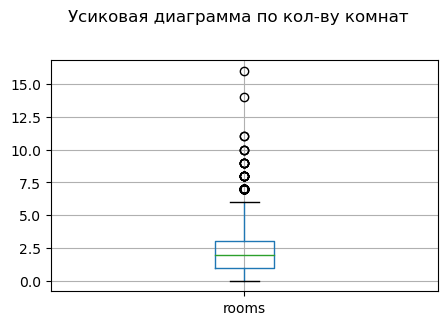

In [67]:
data.boxplot(column='rooms', figsize=(5, 3))
plt.suptitle('Усиковая диаграмма по кол-ву комнат', x=0.5, y=1.05, ha='center', fontsize='large');

In [68]:
data.pivot_table(index='rooms', values='total_area', aggfunc='count')

,total_area
rooms,
0,194
1,8033
2,7936
3,5800
4,1170
5,313
6,100
7,42
8,10


In [69]:
data = data[data['rooms'] <= 8]

**Вывод** Больше всего объявлений с 1- и 2-комнатными квартирами. Много объявлений с 3-х и 4-комнатными квартирами, но так же присутствуют в единичных случаях объявления с более 8 комнатами в квартире. Их из выборки удалили

**Проведём анализ цены объектов**

In [70]:
data['last_price'].describe()

count        23,598.00
mean      6,270,511.00
std       7,587,858.16
min          12,190.00
25%       3,400,000.00
50%       4,600,000.00
75%       6,750,000.00
max     330,000,000.00
Name: last_price, dtype: float64

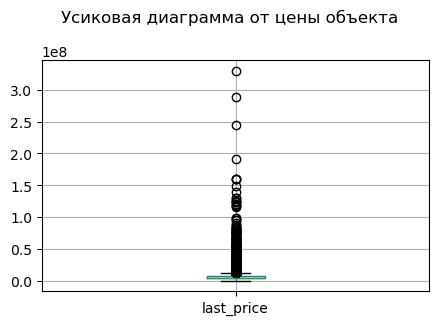

In [71]:
data.boxplot(column='last_price', figsize=(5, 3))
plt.suptitle('Усиковая диаграмма от цены объекта', x=0.5, y=1.05, ha='center', fontsize='large');

Сразу удалим все объявления с ценой свыше 100млн

In [72]:
data = data[data['last_price'] < 100000000]

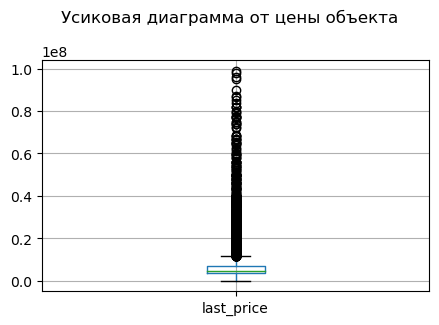

In [73]:
data.boxplot(column='last_price', figsize=(5, 3));
plt.suptitle('Усиковая диаграмма от цены объекта', x=0.5, y=1.05, ha='center', fontsize='large');

Удалим объявления с ценой свыше 20млн

In [74]:
data = data[data['last_price'] < 20000000]

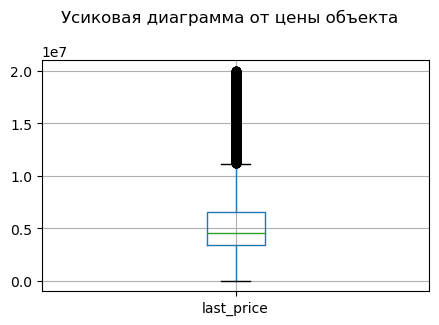

In [75]:
data.boxplot(column='last_price', figsize=(5, 3));
plt.suptitle('Усиковая диаграмма от цены объекта', x=0.5, y=1.05, ha='center', fontsize='large');

Посмотрим на цены объектов в низком диапазоне

In [76]:
data['last_price'].min()

12190.0

In [77]:
data[data['last_price'] == data['last_price'].min()]

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,metr_price,dw_exposition,month_exposition,year_exposition,floor_category,center_km
8793,7,"12,190.00",109.00,2019-03-20,2,2.75,25.00,32.00,25,False,...,805.00,0.00,NaN,8.00,111.83,2,3,2019,последний,9.00


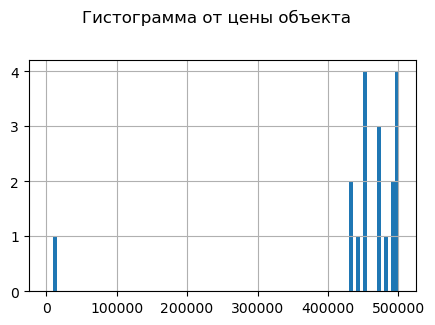

In [78]:
data['last_price'].hist(bins=100, figsize=(5,3), range=(0,500000))
plt.suptitle('Гистограмма от цены объекта', x=0.5, y=1.05, ha='center', fontsize='large');

In [79]:
data[data['last_price'] <500000]

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,metr_price,dw_exposition,month_exposition,year_exposition,floor_category,center_km
5698,7,"450,000.00",42.00,2017-07-31,2,2.65,1.00,23.00,1,False,...,NaN,NaN,NaN,233.00,"10,714.29",0,7,2017,первый,NaN
6859,6,"490,000.00",40.00,2017-12-11,1,2.65,5.00,22.84,3,False,...,NaN,NaN,NaN,43.00,"12,250.00",0,12,2017,другой,NaN
8793,7,"12,190.00",109.00,2019-03-20,2,2.75,25.00,32.00,25,False,...,805.00,0.00,NaN,8.00,111.83,2,3,2019,последний,9.00
9581,7,"450,000.00",43.40,2018-08-31,2,2.65,5.00,30.30,3,False,...,NaN,NaN,NaN,96.00,"10,368.66",4,8,2018,другой,NaN
10782,3,"490,000.00",29.10,2016-05-05,1,2.50,5.00,17.00,5,False,...,NaN,NaN,NaN,719.00,"16,838.49",3,5,2016,последний,NaN
14911,5,"430,000.00",54.00,2018-06-26,2,2.65,3.00,30.83,3,False,...,NaN,NaN,NaN,44.00,"7,962.96",1,6,2018,последний,NaN
16032,8,"480,000.00",32.00,2019-01-06,1,2.65,2.00,16.00,1,False,...,NaN,NaN,NaN,83.00,"15,000.00",6,1,2019,первый,NaN
16219,14,"450,000.00",38.50,2018-07-11,2,2.65,2.00,21.98,1,False,...,NaN,NaN,NaN,45.00,"11,688.31",2,7,2018,первый,NaN
16274,18,"440,000.00",40.00,2018-07-10,1,2.65,5.00,22.84,1,False,...,NaN,NaN,NaN,45.00,"11,000.00",1,7,2018,первый,NaN
17456,7,"430,000.00",30.40,2019-04-22,1,2.65,2.00,16.00,1,False,...,NaN,NaN,NaN,NaN,"14,144.74",0,4,2019,первый,NaN


In [80]:
data = data[data['last_price'] != 12190.0]

Видим одно объявление с явной аномалией в данных. Все объявления стоимость до 500тыс - это малометражное жильё за пределами Санкт-Петербурга, но одно объявление - это квартира площадью 109м2 в центре Санкт-Петербурга стоимость 12тыс. Как исправить данные мы не знаем, поэтому это объявление удаляем из выборки

In [81]:
data['last_price'].describe()

count       22,949.00
mean     5,412,243.87
std      3,193,987.62
min        430,000.00
25%      3,400,000.00
50%      4,550,000.00
75%      6,500,000.00
max     19,999,000.00
Name: last_price, dtype: float64

**Вывод** Средняя стоимость квартиры - 5.4млн, медианное значение составляет 4.6м2. Среди объявлений удалены квартиры с аномальными значениями цен

**Проведём анализ высоты потолков**

In [82]:
data['ceiling_height'].describe()

count   22,949.00
mean         2.71
std          1.00
min          1.00
25%          2.60
50%          2.65
75%          2.70
max        100.00
Name: ceiling_height, dtype: float64

Построим гистограммы высоты потолков: на всём диапазоне, на ожидаемом диапазоне от 0 до 5м и в области аномалий от 5м

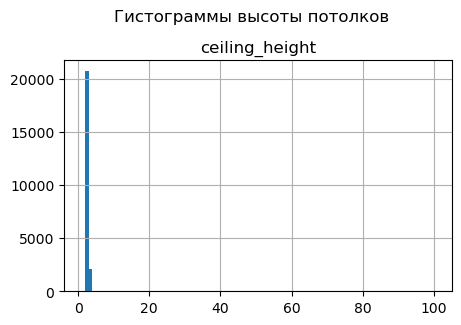

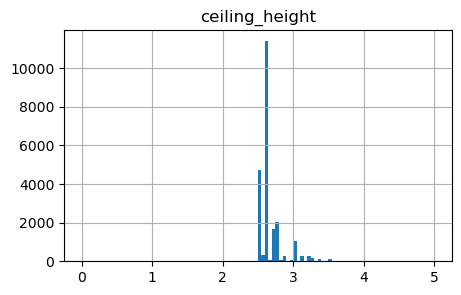

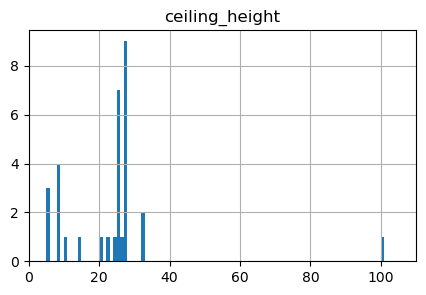

In [83]:
data.hist('ceiling_height', bins=100, figsize=(5,3));
plt.suptitle('Гистограммы высоты потолков', x=0.5, y=1.05, ha='center', fontsize='large');
data.hist('ceiling_height', bins=100, range=(0,5), figsize=(5,3));
data.hist('ceiling_height', bins=100, range=(5,105), figsize=(5,3));

In [84]:
data[data['ceiling_height'] > 10]

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,metr_price,dw_exposition,month_exposition,year_exposition,floor_category,center_km
355,17,"3,600,000.00",55.20,2018-07-12,2,25.00,5.00,32.00,2,False,...,NaN,NaN,NaN,259.00,"65,217.39",3,7,2018,другой,NaN
3148,14,"2,900,000.00",75.00,2018-11-12,3,32.00,3.00,53.00,2,False,...,NaN,NaN,NaN,NaN,"38,666.67",0,11,2018,другой,NaN
4643,0,"4,300,000.00",45.00,2018-02-01,2,25.00,9.00,30.00,2,False,...,658.00,1.00,331.00,181.00,"95,555.56",3,2,2018,другой,13.00
4876,7,"3,000,000.00",25.00,2017-09-27,0,27.00,25.00,17.00,17,False,...,NaN,NaN,NaN,28.00,"120,000.00",2,9,2017,другой,NaN
5076,0,"3,850,000.00",30.50,2018-10-03,1,24.00,5.00,19.50,1,True,...,397.00,1.00,578.00,7.00,"126,229.51",2,10,2018,первый,8.00
5246,0,"2,500,000.00",54.00,2017-10-13,2,27.00,5.00,30.00,3,False,...,NaN,NaN,NaN,540.00,"46,296.30",4,10,2017,другой,NaN
5669,4,"4,400,000.00",50.00,2017-08-08,2,26.00,9.00,21.30,3,False,...,305.00,0.00,NaN,267.00,"88,000.00",1,8,2017,другой,11.00
5807,17,"8,150,000.00",80.00,2019-01-09,2,27.00,36.00,41.00,13,False,...,NaN,3.00,80.00,38.00,"101,875.00",2,1,2019,другой,20.00
6246,6,"3,300,000.00",44.40,2019-03-25,2,25.00,5.00,31.30,5,False,...,417.00,2.00,73.00,NaN,"74,324.32",0,3,2019,последний,51.00
9379,5,"3,950,000.00",42.00,2017-03-26,3,25.00,5.00,30.00,2,False,...,NaN,0.00,NaN,NaN,"94,047.62",6,3,2017,другой,14.00


При рассмотрении объявлений квартир с высотой потолков больше 10м видим много записей со значениями в диапазоне от 20 до 32. Логично предположить, что на самом деле это значения 2м и 3.2м. Обработаем такие значений

In [85]:
data['ceiling_height'] = data['ceiling_height'].where(~((data['ceiling_height'] >= 20) & (data['ceiling_height'] <= 32)), data['ceiling_height'] / 10)

Так же видим одно объявление с высотой потолков 100м. Его удалим

In [86]:
data = data[data['ceiling_height'] != 100.0]

Рассмотрим объявления с высотой потолков ниже 2м

In [87]:
data[data['ceiling_height'] < 2]

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,metr_price,dw_exposition,month_exposition,year_exposition,floor_category,center_km
5712,5,"1,500,000.00",42.80,2017-08-14,2,1.20,2.00,27.50,1,False,...,NaN,NaN,NaN,248.00,"35,046.73",0,8,2017,первый,NaN
16934,5,"4,100,000.00",40.00,2017-10-17,1,1.75,37.00,17.40,5,False,...,NaN,3.00,80.00,71.00,"102,500.00",1,10,2017,другой,20.00
22590,16,"6,000,000.00",55.00,2018-10-31,2,1.00,12.00,32.40,7,False,...,293.00,2.00,289.00,13.00,"109,090.91",2,10,2018,другой,14.00


Есть 2 записи со значениями 1м, 1.2м, 1.75м. Можно предположить, что имелись в виду значения 2м, 2.2м и 2.75м. 

In [88]:
data['ceiling_height'] = data['ceiling_height'].where(~((data['ceiling_height'] < 2)), data['ceiling_height'] + 1)

In [89]:
data['ceiling_height'].describe()

count   22,948.00
mean         2.69
std          0.23
min          2.00
25%          2.60
50%          2.65
75%          2.70
max         14.00
Name: ceiling_height, dtype: float64

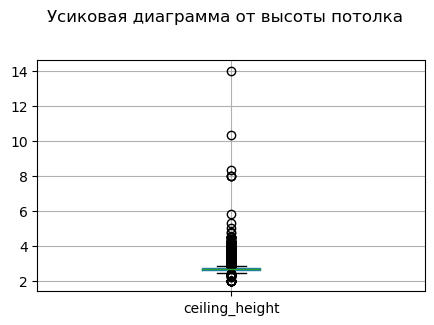

In [90]:
data.boxplot(column='ceiling_height', figsize=(5, 3));
plt.suptitle('Усиковая диаграмма от высоты потолка', x=0.5, y=1.05, ha='center', fontsize='large');

In [91]:
data = data[data['ceiling_height'] < 8]

**Вывод** Большинство объявлений с высотой потолков в диапазоне 2.5м-2.8м. Есть несколько объявлений с недвижимостью с высокими потолками. Часть аномальных значений попытались исправить, остальные удалили 

**Проведём анализ тип этажа квартиры**

In [92]:
data.pivot_table(index='floor_category', values='total_area', aggfunc='count')

,total_area
floor_category,
другой,16890
первый,2867
последний,3185


**Вывод** Ожидаемо большинство квартир в средних этажах.

**Проведём анализ по общему количеству этажей в доме**

In [93]:
data['floors_total'].describe()

count   22,858.00
mean        10.74
std          6.63
min          1.00
25%          5.00
50%          9.00
75%         16.00
max         60.00
Name: floors_total, dtype: float64

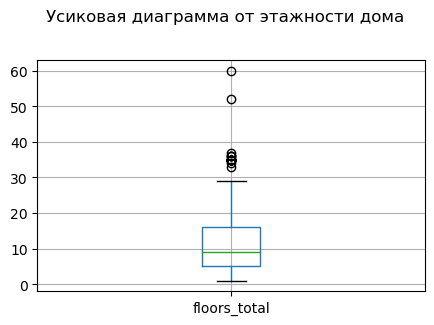

In [94]:
data.boxplot(column='floors_total', figsize=(5, 3));
plt.suptitle('Усиковая диаграмма от этажности дома', x=0.5, y=1.05, ha='center', fontsize='large');

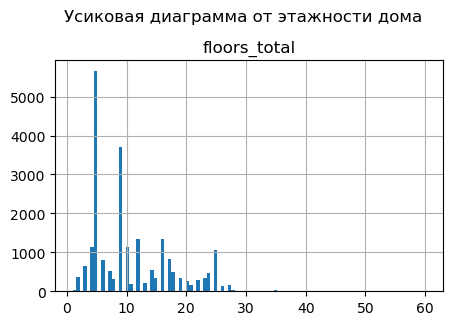

In [95]:
data.hist('floors_total', bins=100, figsize=(5,3));
plt.suptitle('Усиковая диаграмма от этажности дома', x=0.5, y=1.05, ha='center', fontsize='large');

In [96]:
data = data[(data['floors_total'] < 30) | (data['floors_total'].isna())]

In [97]:
(data
 .pivot_table(index='floors_total', values='total_area', aggfunc='count')
 .sort_values(by='total_area', ascending=False)
 .head())

,total_area
floors_total,
5.00,5650
9.00,3714
16.00,1347
12.00,1332
4.00,1145


**Вывод** Большинство домов стандартной для России этажности: 5, 9, 16, 12 этажей. Удалены несколько объявлений в небоскрёбах высотой больше 30 этажей

**Проведём анализ по расстоянию до центра города**

In [98]:
data['cityCenters_nearest'].describe()

count   17,409.00
mean    14,495.66
std      8,578.44
min        208.00
25%      9,816.00
50%     13,277.00
75%     16,453.00
max     65,968.00
Name: cityCenters_nearest, dtype: float64

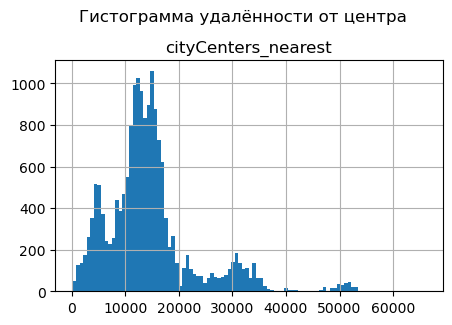

In [99]:
data.hist('cityCenters_nearest', bins=100, figsize=(5,3));
plt.suptitle('Гистограмма удалённости от центра', x=0.5, y=1.05, ha='center', fontsize='large');

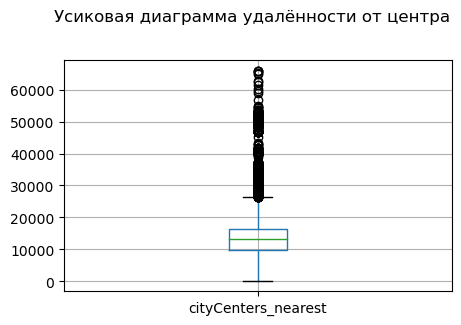

In [100]:
data.boxplot(column='cityCenters_nearest', figsize=(5, 3));
plt.suptitle('Усиковая диаграмма удалённости от центра', x=0.5, y=1.05, ha='center', fontsize='large');

In [101]:
data = data[(data['cityCenters_nearest'] < 40000) | (data['cityCenters_nearest'].isna())]

In [102]:
round(data['cityCenters_nearest'].count() / data['total_area'].count() * 100, 1)

75.7

**Вывод** Чаще всего встречаются объявления с недвижимостью , находящайся в 9-16км от центра города. 

**Проведём анализ по расстоянию до ближайшего парка**

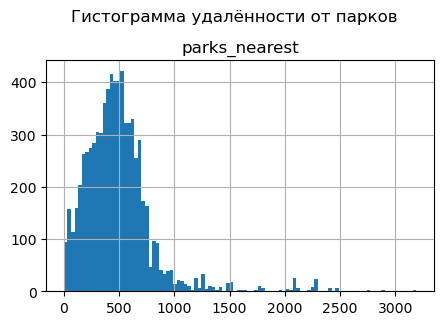

In [103]:
data.hist('parks_nearest', bins=100, figsize=(5,3));
plt.suptitle('Гистограмма удалённости от парков', x=0.5, y=1.05, ha='center', fontsize='large');

In [104]:
data['parks_nearest'].describe()

count   7,408.00
mean      495.51
std       341.51
min         1.00
25%       293.00
50%       458.00
75%       617.00
max     3,190.00
Name: parks_nearest, dtype: float64

In [105]:
round(data['parks_nearest'].count() / data['total_area'].count() * 100, 1)

32.8

**Вывод** Чаще всего встречаются объявления с недвижимостью, находящайся в 500м от ближайшего парка. Но по данному параметру заполнено только 32.7% объявлений, поэтому данная аналита является неполной

**Изучим, как быстро продавались квартиры**

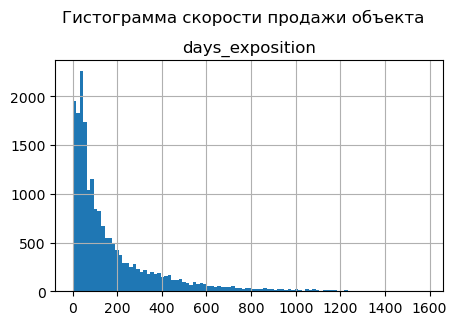

In [106]:
data.hist('days_exposition', bins=100, figsize=(5,3))
plt.suptitle('Гистограмма скорости продажи объекта', x=0.5, y=1.05, ha='center', fontsize='large');

In [107]:
data['days_exposition'].describe()

count   19,685.00
mean       177.59
std        216.25
min          1.00
25%         44.00
50%         93.00
75%        226.00
max      1,580.00
Name: days_exposition, dtype: float64

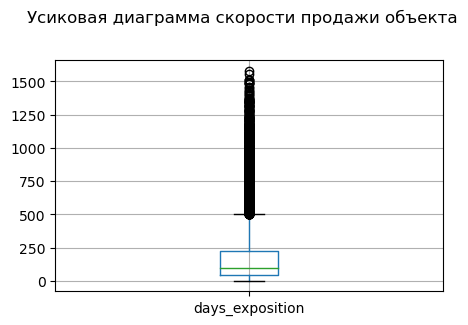

In [108]:
data.boxplot('days_exposition', figsize=(5,3));
plt.suptitle('Усиковая диаграмма скорости продажи объекта', x=0.5, y=1.05, ha='center', fontsize='large');

Подробнее рассмотрим диапазон от 0 до 200 дней

In [109]:
data[data['days_exposition'] < 200]

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,metr_price,dw_exposition,month_exposition,year_exposition,floor_category,center_km
1,7,"3,350,000.00",40.40,2018-12-04,1,2.65,11.00,18.60,1,False,...,NaN,0.00,NaN,81.00,"82,920.79",1,12,2018,первый,19.00
4,2,"10,000,000.00",100.00,2018-06-19,2,3.03,14.00,32.00,13,False,...,112.00,1.00,48.00,121.00,"100,000.00",1,6,2018,другой,8.00
5,10,"2,890,000.00",30.40,2018-09-10,1,2.65,12.00,14.40,5,False,...,NaN,NaN,NaN,55.00,"95,065.79",0,9,2018,другой,NaN
6,6,"3,700,000.00",37.30,2017-11-02,1,2.65,26.00,10.60,6,False,...,NaN,0.00,NaN,155.00,"99,195.71",3,11,2017,другой,19.00
8,20,"2,900,000.00",33.16,2018-05-23,1,2.65,27.00,15.43,26,False,...,NaN,NaN,NaN,189.00,"87,454.76",2,5,2018,другой,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23687,6,"3,200,000.00",39.00,2017-12-16,1,2.65,9.00,20.00,6,False,...,NaN,0.00,NaN,38.00,"82,051.28",5,12,2017,другой,17.00
23688,19,"9,200,000.00",101.00,2019-04-01,3,3.05,15.00,63.00,12,False,...,NaN,0.00,NaN,23.00,"91,089.11",0,4,2019,другой,14.00
23689,13,"3,550,000.00",35.30,2018-02-28,1,2.86,15.00,16.30,4,False,...,353.00,2.00,652.00,29.00,"100,566.57",2,2,2018,другой,16.00
23690,3,"5,500,000.00",52.00,2018-07-19,2,2.65,5.00,31.00,2,False,...,300.00,0.00,NaN,15.00,"105,769.23",3,7,2018,другой,6.00


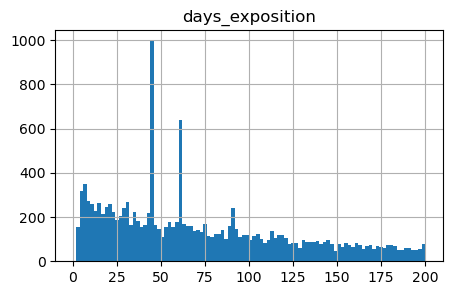

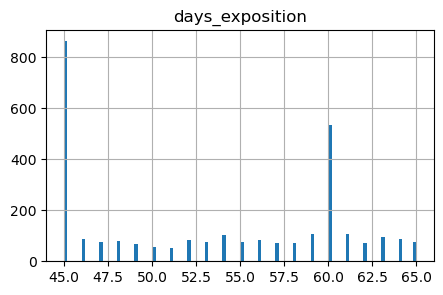

In [110]:
data.hist('days_exposition', bins=100, range=(0,200), figsize=(5,3));
data.hist('days_exposition', bins=100, range=(45,65), figsize=(5,3));

**Вывод** Чаще всего квартиры продаются в срок 41-237 дней после размещения объявления. Продажи быстрее 44 дней  можно назвать быстрыми. С другой стороны присутсвуют квартиры, которые продавались дольше 500дней, что можно назвать необычно долгими.
Анамально много квартир продалось ровно за 45 и 60 дней

**Определим факторы, которые влияют на стоимость объекта.**

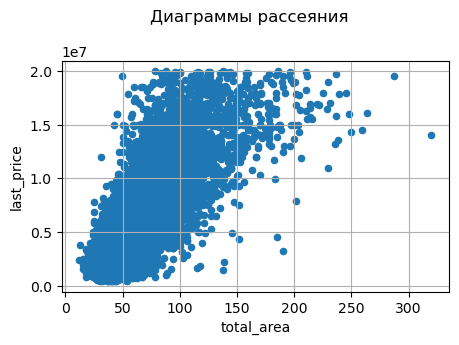

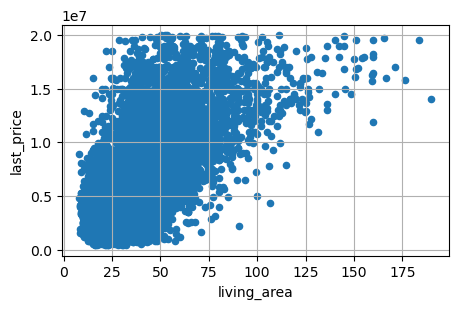

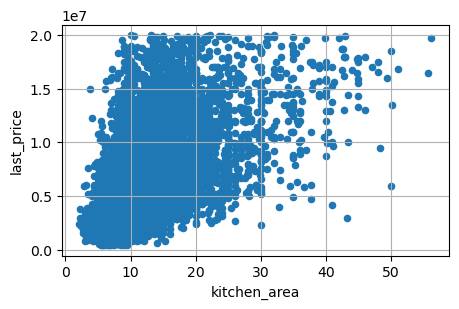

In [111]:
data.plot(x='total_area', y='last_price', kind='scatter', grid=True, figsize=(5,3));
plt.suptitle('Диаграммы рассеяния', x=0.5, y=1.05, ha='center', fontsize='large');
data.plot(x='living_area', y='last_price', kind='scatter', grid=True, figsize=(5,3));
data.plot(x='kitchen_area', y='last_price', kind='scatter', grid=True, figsize=(5,3));

In [112]:
data[['last_price', 'total_area', 'living_area', 'kitchen_area']].corr()['last_price']

last_price     1.00
total_area     0.77
living_area    0.67
kitchen_area   0.60
Name: last_price, dtype: float64

In [113]:
rooms_pivot = data.pivot_table(index='rooms', values=['last_price'], aggfunc='median')
rooms_pivot

,last_price
rooms,
0,"2,700,000.00"
1,"3,600,000.00"
2,"4,750,000.00"
3,"6,000,000.00"
4,"8,200,000.00"
5,"11,300,000.00"
6,"13,400,500.00"
7,"15,350,000.00"
8,"16,500,000.00"


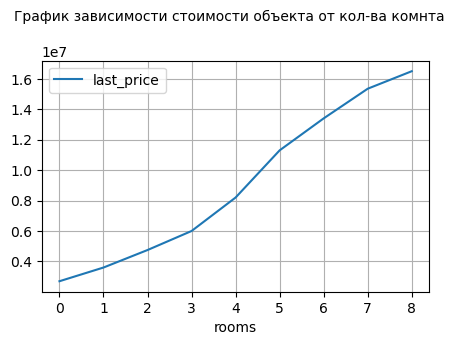

In [114]:
rooms_pivot.plot(grid=True, figsize=(5,3))
plt.suptitle('График зависимости стоимости объекта от кол-ва комнта', x=0.5, y=1.05, ha='center', fontsize='medium');

In [115]:
floor_pivot = data.pivot_table(index='floor_category', values='last_price', aggfunc='median')
floor_pivot

,last_price
floor_category,
другой,"4,750,000.00"
первый,"3,900,000.00"
последний,"4,200,000.00"


In [116]:
dw_pivot = data.pivot_table(index='dw_exposition', values='last_price', aggfunc='median')
dw_pivot

,last_price
dw_exposition,
0,"4,592,000.00"
1,"4,650,000.00"
2,"4,600,000.00"
3,"4,550,000.00"
4,"4,500,000.00"
5,"4,500,000.00"
6,"4,500,000.00"


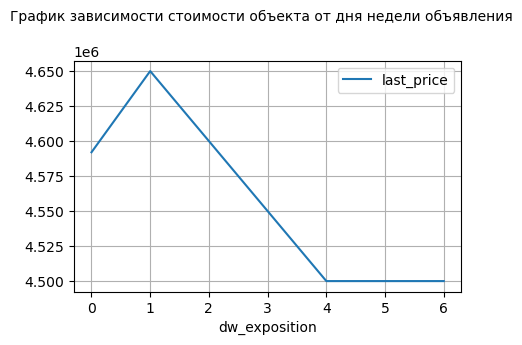

In [117]:
dw_pivot.plot(grid=True, figsize=(5,3));
plt.suptitle('График зависимости стоимости объекта от дня недели объявления', x=0.5, y=1.05, ha='center', fontsize='medium');

In [118]:
month_pivot = data.pivot_table(index='month_exposition', values='last_price', aggfunc='median')
month_pivot

,last_price
month_exposition,
1,"4,500,000.00"
2,"4,600,000.00"
3,"4,600,000.00"
4,"4,750,000.00"
5,"4,500,000.00"
6,"4,350,000.00"
7,"4,575,000.00"
8,"4,500,000.00"
9,"4,635,000.00"


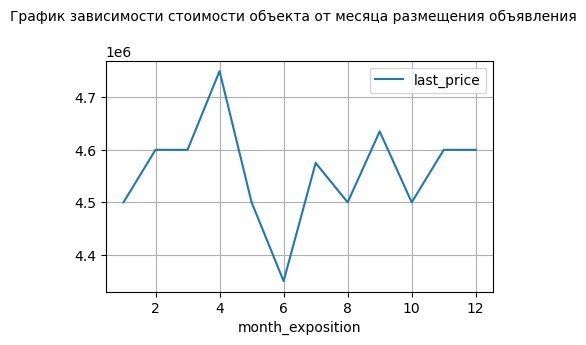

In [119]:
month_pivot.plot(grid=True, figsize=(5,3));
plt.suptitle('График зависимости стоимости объекта от месяца размещения объявления', x=0.5, y=1.05, ha='center', fontsize='medium');

In [120]:
year_pivot = data.pivot_table(index='year_exposition', values='last_price', aggfunc='median')
year_pivot

,last_price
year_exposition,
2014,"6,750,000.00"
2015,"5,130,296.50"
2016,"4,450,000.00"
2017,"4,450,000.00"
2018,"4,500,000.00"
2019,"5,000,000.00"


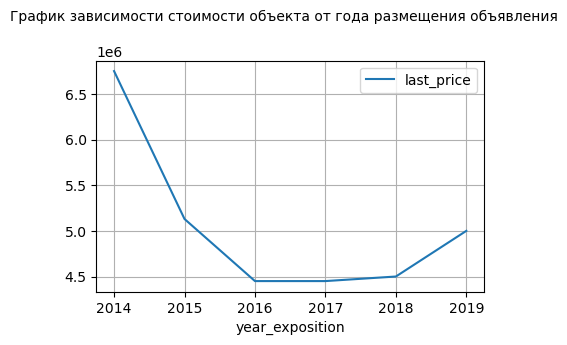

In [121]:
year_pivot.plot(grid=True, figsize=(5,3));
plt.suptitle('График зависимости стоимости объекта от года размещения объявления', x=0.5, y=1.05, ha='center', fontsize='medium');

**Выводы** 
* Наибольшая зависимось конечной цены квартиры от её общей площади. Так же высокая корреляция просматривается с жилой площадью и площадью кухни.
* По графикам видно, что количество комнат напрямую влияет на стоимость жилья.
* Жильё на 1м этаже дешевле, чем остальное. Жильё на средних этажах в среднем дороже.
* День недели и месяц объявления влияют незначительно
* Самое дорогое жильё было в 2014 году, потом сильно дешевело вплоть до 2016. До 2018 цены на рынке не менялись, и только в 2019г начали немного расти

**Посчитаем среднюю цену одного квадратного метра в 10 населённых пунктах с наибольшим числом объявлений**

In [122]:
pivot = (data
 .pivot_table(index='locality_name', values='metr_price', aggfunc=['count', 'mean'])
)
pivot.columns = ['count', 'mean']
pivot = pivot.sort_values(by='count', ascending=False).head(10)
pivot.sort_values(by='mean', ascending=False)

,count,mean
locality_name,,
Санкт-Петербург,14957,"108,576.97"
Пушкин,358,"101,864.46"
Кудрово,472,"95,324.93"
посёлок Парголово,327,"90,175.91"
Мурино,589,"86,061.68"
посёлок Шушары,440,"78,677.36"
Колпино,337,"75,333.30"
Гатчина,307,"68,746.15"
Всеволожск,397,"67,214.25"


**Вывод** Из топ-10 по количеству объявлений самая дорогая стоимость квадратного метра в городах Санкт-Петербурге, Пушкине и Кудрово, самая низкая стоимость в Выборге, Всеволожске и Гатчине

**Рассчитаем среднюю стоимость квартир в зависимости от удаления от центра Санкт-Петербурга**

In [123]:
spb_data = data[data['locality_name'] == 'Санкт-Петербург']
spb_data = spb_data.pivot_table(index='center_km', values='last_price', aggfunc='mean')
spb_data

,last_price
center_km,
0.00,"10,198,571.43"
1.00,"10,440,392.15"
2.00,"9,965,062.75"
3.00,"9,022,471.11"
4.00,"9,363,659.84"
5.00,"9,389,923.27"
6.00,"8,583,334.75"
7.00,"7,922,983.24"
8.00,"7,852,553.77"


<Axes: xlabel='center_km'>

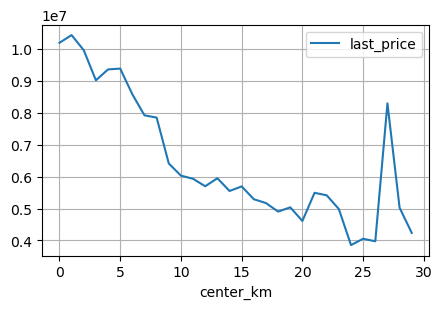

In [124]:
spb_data.plot( grid=True, figsize=(5,3))

**Выводы**  С удалением от центра города стоимость жилья снижается. Первые 10км цена снижается довольно быстро. С 10 по 20км скорость изменения цены замедляется. После 20го км появляются повышения в цене, связанные, видимо, с более дорогим жильём в частном секторе

### Общий вывод

Предварительно были исследованы параметры объектов недвижимости и обработаны аномальные и  выбивающиеся значения, приведены типы данных. При необходимости такие значения были удалены для очистки данных для последующего изучения. Обработаны неявные дупликаты в названиях населённых пунктов. Добавлены вспомогательные столбцы, помогающие в анализе.

Проведён анализ показателей объявлений
* Средняя площадь квартиры - 60м2, медианное значение - 52м2. 
* Среднее значение жилой площади - 34,1 м2, медиана - 30м2
* Средняя площадь кухни - 10,5м2, медианное значение составляет 9м2

Больше всего объявлений с 1- и 2-комнатными квартирами. Много объявлений с 3-х и 4-комнатными квартирами. Большинство объявлений с высотой потолков в диапазоне 2.5м-2.8м. Есть несколько объявлений с недвижимостью с высокими потолками. Большинство домов стандартной для России этажности: 5, 9, 16, 12 этажей.

Чаще всего квартиры продаются в срок 41-237 дней после размещения объявления. Продажи быстрее 44 дней можно назвать быстрыми. С другой стороны присутсвуют квартиры, которые продавались дольше 500дней, что можно назвать необычно долгими. Анамально много квартир продалось ровно за 45 и 60 дней

Средняя стоимость квартиры - 5.4млн, медианное значение составляет 4.6м2

При исследовании зависимости цены продажи объекта от других показателей было обнаружено:
* Наибольшая зависимось конечной цены квартиры от её общей площади. Так же высокая корреляция просматривается с жилой площадью и площадью кухни.
* Количество комнат напрямую влияет на стоимость жилья.
* Жильё на 1м этаже дешевле, чем остальное. Жильё на средних этажах в среднем дороже.
* День недели и месяц объявления фактически не влияют на стоимость жилья
* Самое дорогое жильё было в 2014 году, потом сильно дешевело вплоть до 2016. До 2018 цены на рынке не менялись, и только в 2019г начали немного расти.

При исследовании топа населённых пунктов по количеству объявлений были определены города с самым дорогим жильём за 1 квадратный метр - Санкт-Петербург, Пушкин и Кудрово. Самый дешевый квадратный метр в этом топе в Выборге, Всеволожске и Гатчине.

С удалением от центра города стоимость жилья снижается. Первые 10км цена снижается довольно быстро. С 10 по 20км скорость изменения цены замедляется. После 20го км появляются повышения в цене, связанные, видимо, с более дорогим жильём в частном секторе